In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tsai.all import *
from openavalancheproject.tsai_utilities import *
from bayes_opt import BayesianOptimization

In [3]:
import mlflow
from azureml.core import Workspace

In [ ]:
ws = Workspace.from_config('../../ML/')
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

Performing interactive authentication. Please follow the instructions on the terminal.


Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


In [3]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1

In [4]:
interesting_labels =  ['Day1DangerAboveTreeline',
                         'Day1DangerBelowTreeline',
                         'Day1DangerNearTreeline']

In [5]:
class TSStandardizeNanMeanReplaceNan(Transform):
    #method to standardize each batch while also replacing any nans with the mean value before standarization
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, feature_means=None, std=None, feature_std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.feature_means = feature_means
        self.feature_std = feature_std
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
        
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [6]:
l = interesting_labels[0]
print('On: ' + l)
label = l
file_label = 'co_' + l + '_small'
fname = ml_path + '/X_all_' + file_label + '.npy'
#mlflow.set_experiment(file_label)

        
X = np.load(fname, mmap_mode='r')
X = X[:,:,:]
utils = TSAIUtilities(X, label)
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'
feature_means = utils.get_feature_means(from_cache=means_fn)
feature_std = utils.get_feature_std(from_cache=std_fn)
i = 0
y_train_df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  
y_test_df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
y_df = pd.concat([y_train_df, y_test_df]).reset_index(drop=True)
y, cat_dict = utils.get_y_as_cat(y_df)
print(cat_dict)
train_test_split = 5000
num_y = 1000

splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_y)]).shuffle())
    
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan(feature_means=feature_means, feature_std=feature_std)], num_workers=0)
 
              

  


On: Day1DangerAboveTreeline
{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}


In [53]:
pbounds = {
    'hidden': (50, 300),
    'layers': (3, 10),
    'dropout': (0, .9),
    'fc_dropout': (0, .9),
    'bidirectional': (0, 1),
    'model': (0, 1)
}


    #models = [#InceptionTime(dls.vars, dls.c), 
              #ResNet(dls.vars, dls.c), 
              #ResNetPlus(dls.vars, dls.c),
              #--MLP(dls.vars, dls.c, 7),
              #FCN(dls.vars, dls.c),
              #FCNPlus(dls.vars, dls.c),
              #ResCNN(dls.vars, dls.c),
              #RNN(dls.vars, dls.c),
              #RNNPlus(dls.vars, dls.c)]
              #LSTM(dls.vars, dls.c),
            
              #LSTMPlus(dls.vars, dls.c)
            
              #XceptionTime(dls.vars, dls.c),
              #XceptionTimePlus(dls.vars, dls.c),
              #RNN_FCN(dls.vars, dls.c, seq_len=30),
              #RNN_FCNPlus(dls.vars, dls.c, seq_len=30),              
              #TransformerModel(dls.vars, dls.c),
              #OmniScaleCNN(dls.vars, dls.c, seq_len=7),
              #mWDN(dls.vars, dls.c, seq_len=30),
              #TCN(dls.vars, dls.c),
              #XCM(dls.vars, dls.c, seq_len=30)]

In [54]:
def train(model=0, hidden=100, layers=3, dropout=.75, fc_dropout=.75, bidirectional=0):
    #convert to ints where necesary
    model = int(round(model))
    h = int(hidden)
    l = int(layers)
    
    d = dropout
    f = fc_dropout
    b = False
    if int(round(bidirectional)) == 1:
        b = True
    
    
    models =  [LSTM(dls.vars, 
                dls.c, 
                hidden_size=h, 
                n_layers=l, 
                rnn_dropout=d,
                bidirectional=b,
                fc_dropout=f),
                                        
           LSTMPlus(dls.vars, 
                    dls.c,
                    hidden_size=h, 
                    n_layers=l, 
                    rnn_dropout=d,
                    bidirectional=b,
                    fc_dropout=f)]
    
    m = models[model]
                      
    print('On Model ' + str(type(m)))
    print('With lookback 180')
    print('Num Hidden ' + str(h))
    print('Num Layers ' + str(l))
    print('RNN Dropout ' + str(d))
    print('FC Dropout ' + str(f))
    print('Bidirectional ' + str(b))
    mlflow.log_param('Model', str(type(m)))
    mlflow.log_param('Lookback', 180)
    mlflow.log_param('Num Hidden ', h)
    mlflow.log_param('Num Layers ', l)
    mlflow.log_param('RNN Dropout ',d)
    mlflow.log_param('FC Dropout ', f)
    mlflow.log_param('Bidirectional ',b)
    learn = Learner(dls, m, metrics=accuracy)

    learn.fit_one_cycle(5, lr_max=1e-2, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=2))     

    learn.recorder.plot_metrics()
    interp = ClassificationInterpretation.from_learner(learn)
    cm = interp.plot_confusion_matrix(normalize=True)
    plt.show()

    cm = interp.confusion_matrix()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for r in range(len(cm)):
        for c in range(len(cm[r])):
            mlflow.log_metric('Actual ' + str(r) + ' Predicted ' + str(c), cm[r,c])

    d1,t1 = flatten_check(interp.decoded, interp.targs)
    a = skm.accuracy_score(t1, d1)
    mlflow.log_metric('Test Accuracy', a)

    mlflow.end_run()
    return a

In [55]:
mlflow.end_run()

In [56]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
logger = JSONLogger(path="./logs180.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [57]:
optimizer = BayesianOptimization(
    f=train,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

|   iter    |  target   | bidire... |  dropout  | fc_dro... |  hidden   |  layers   |   model   |
-------------------------------------------------------------------------------------------------
On Model <class 'tsai.models.RNN.LSTM'>
With lookback 180
Num Hidden 125
Num Layers 4
RNN Dropout 0.6482920440979423
FC Dropout 0.00010293733561039797
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,0.968727,1.039650,0.546000,00:24
1,0.836394,1.117035,0.505000,00:24
2,0.751565,0.977226,0.619000,00:24
3,0.661189,1.242553,0.542000,00:24
4,0.596956,1.326727,0.528000,00:24


No improvement since epoch 2: early stopping


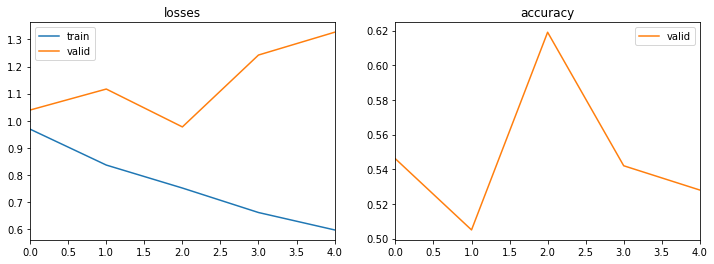

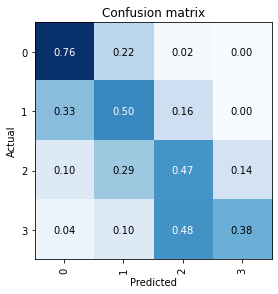

|  1        |  0.528    |  0.417    |  0.6483   |  0.000102 |  125.6    |  4.027    |  0.09234  |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 184
Num Layers 5
RNN Dropout 0.31100465433874297
FC Dropout 0.35709072680760295
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,1.000134,1.166374,0.489000,00:26
1,0.808687,1.066117,0.552000,00:26
2,0.681890,1.489240,0.477000,00:27
3,0.570210,1.544517,0.484000,00:27


No improvement since epoch 1: early stopping


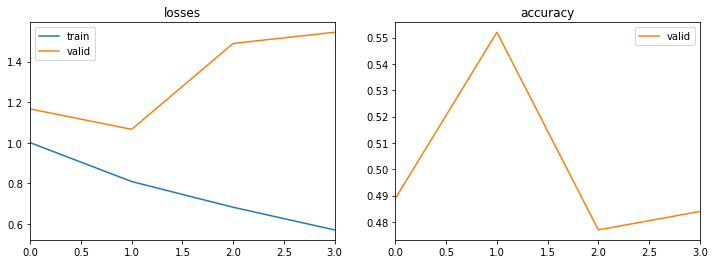

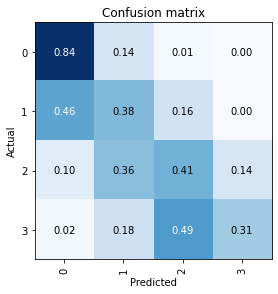

|  2        |  0.484    |  0.1863   |  0.311    |  0.3571   |  184.7    |  5.934    |  0.6852   |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 217
Num Layers 5
RNN Dropout 0.7903056927518509
FC Dropout 0.024648833878133547
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,1.083576,0.952029,0.562000,00:27
1,0.993797,0.908597,0.635000,00:27
2,0.924074,0.890844,0.646000,00:27
3,0.850340,0.924433,0.609000,00:27
4,0.783347,0.946553,0.610000,00:27


No improvement since epoch 2: early stopping


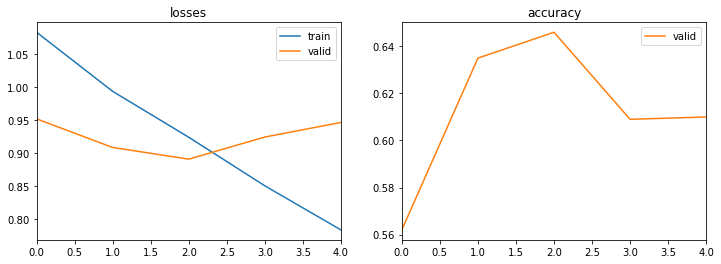

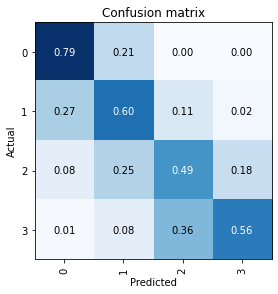

|  3        |  0.61     |  0.2045   |  0.7903   |  0.02465  |  217.6    |  5.921    |  0.5587   |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 292
Num Layers 5
RNN Dropout 0.17829134017639092
FC Dropout 0.720670111807983
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,0.994325,0.964830,0.583000,00:29
1,0.819227,1.031354,0.560000,00:29
2,0.699648,1.542369,0.475000,00:29


No improvement since epoch 0: early stopping


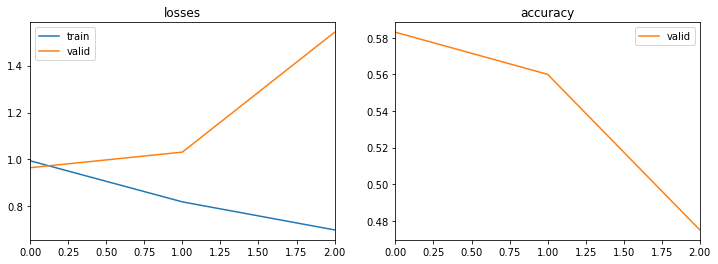

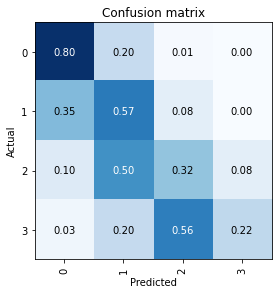

|  4        |  0.475    |  0.1404   |  0.1783   |  0.7207   |  292.1    |  5.194    |  0.6923   |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 59
Num Layers 4
RNN Dropout 0.8051459971534626
FC Dropout 0.07653979023280012
Bidirectional True


epoch,train_loss,valid_loss,accuracy,time
0,1.060543,1.104946,0.562000,00:26
1,0.885179,0.952037,0.612000,00:26
2,0.802183,1.195200,0.574000,00:26
3,0.714298,1.190751,0.591000,00:26


No improvement since epoch 1: early stopping


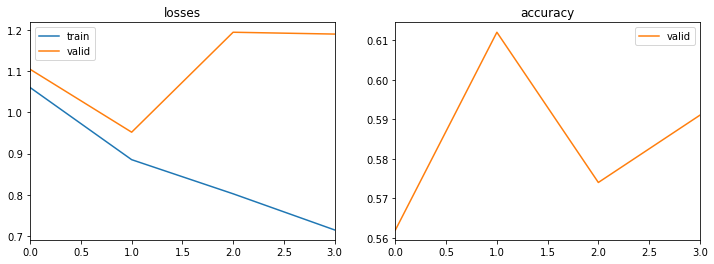

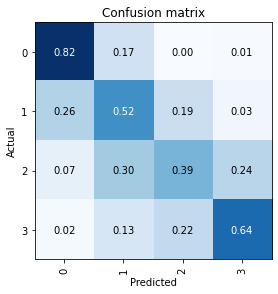

|  5        |  0.591    |  0.8764   |  0.8051   |  0.07654  |  59.76    |  4.189    |  0.8781   |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 217
Num Layers 6
RNN Dropout 0.5710157506763193
FC Dropout 0.3433659462659261
Bidirectional True


epoch,train_loss,valid_loss,accuracy,time
0,0.952821,0.942287,0.580000,00:40
1,0.812119,0.982555,0.556000,00:40
2,0.691376,1.313105,0.544000,00:40


No improvement since epoch 0: early stopping


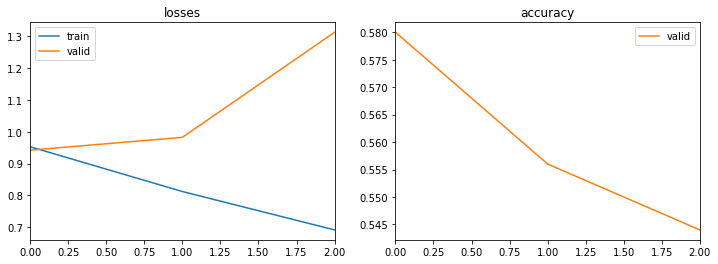

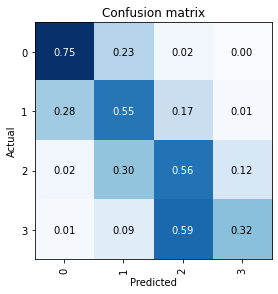

|  6        |  0.544    |  0.6332   |  0.571    |  0.3434   |  217.0    |  6.553    |  0.9745   |
On Model <class 'tsai.models.RNNPlus.LSTMPlus'>
With lookback 180
Num Hidden 217
Num Layers 5
RNN Dropout 0.5510468483636991
FC Dropout 0.6434892982446788
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,1.047159,0.970090,0.558000,00:27
1,0.876337,1.017249,0.577000,00:27
2,0.753806,1.237098,0.513000,00:27


No improvement since epoch 0: early stopping


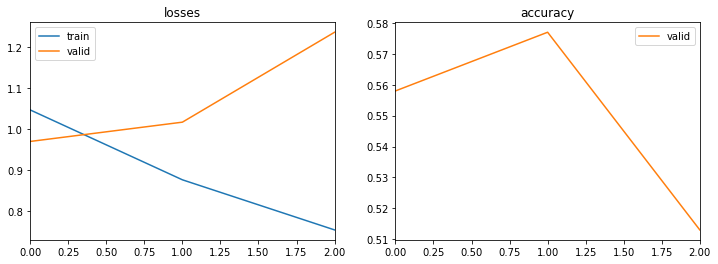

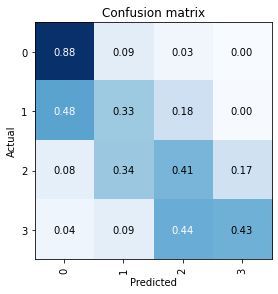

|  7        |  0.513    |  0.2878   |  0.551    |  0.6435   |  217.9    |  5.986    |  0.8323   |
On Model <class 'tsai.models.RNN.LSTM'>
With lookback 180
Num Hidden 217
Num Layers 6
RNN Dropout 0.6365307308065283
FC Dropout 0.13955696862048322
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,1.071230,0.984171,0.550000,00:29
1,0.930765,0.996797,0.545000,00:29
2,0.847322,1.051938,0.524000,00:28


No improvement since epoch 0: early stopping


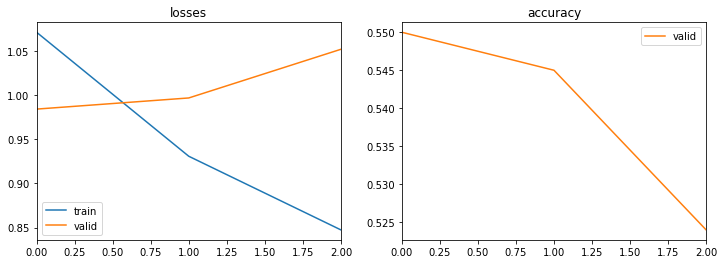

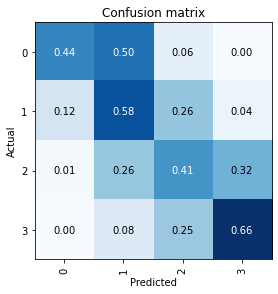

|  8        |  0.524    |  0.1929   |  0.6365   |  0.1396   |  217.4    |  6.091    |  0.401    |
On Model <class 'tsai.models.RNN.LSTM'>
With lookback 180
Num Hidden 267
Num Layers 7
RNN Dropout 0.11006749974569838
FC Dropout 0.656983453310524
Bidirectional False


epoch,train_loss,valid_loss,accuracy,time
0,1.268191,1.142307,0.468000,00:32
1,1.111808,1.067335,0.512000,00:32
2,0.991758,1.021689,0.560000,00:32
3,0.815612,1.311730,0.494000,00:32


No improvement since epoch 1: early stopping


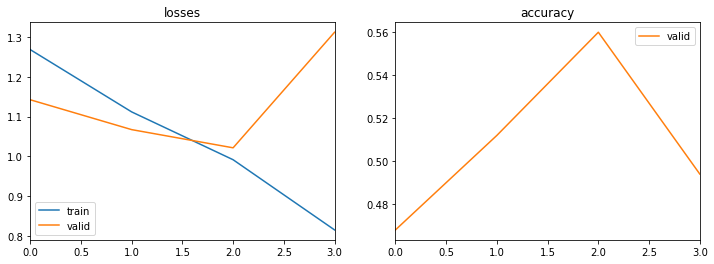

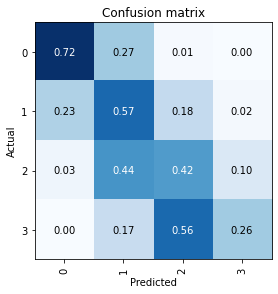

|  9        |  0.494    |  0.4095   |  0.1101   |  0.657    |  267.0    |  7.64     |  0.395    |
On Model <class 'tsai.models.RNN.LSTM'>
With lookback 180
Num Hidden 286
Num Layers 3
RNN Dropout 0.08515077840964043
FC Dropout 0.8879790587238375
Bidirectional True


epoch,train_loss,valid_loss,accuracy,time
0,0.902881,1.416699,0.497000,00:31
1,0.830349,1.208192,0.538000,00:31
2,0.648009,1.305310,0.523000,00:31
3,0.464757,1.746804,0.490000,00:31


No improvement since epoch 1: early stopping


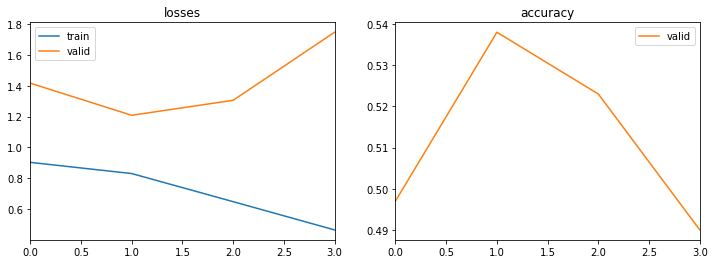

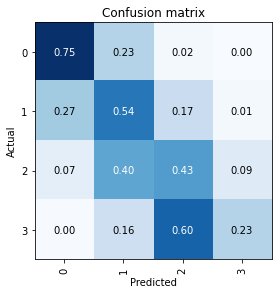

|  10       |  0.49     |  0.9168   |  0.08515  |  0.888    |  286.7    |  3.093    |  0.4541   |
On Model <class 'tsai.models.RNN.LSTM'>
With lookback 180
Num Hidden 227
Num Layers 8
RNN Dropout 0.5162498548243258
FC Dropout 0.2961774380813445
Bidirectional True


epoch,train_loss,valid_loss,accuracy,time
0,1.119686,1.066706,0.486000,00:48
1,1.059868,1.038836,0.599000,00:49
2,0.974836,1.132482,0.524000,00:49


No improvement since epoch 0: early stopping


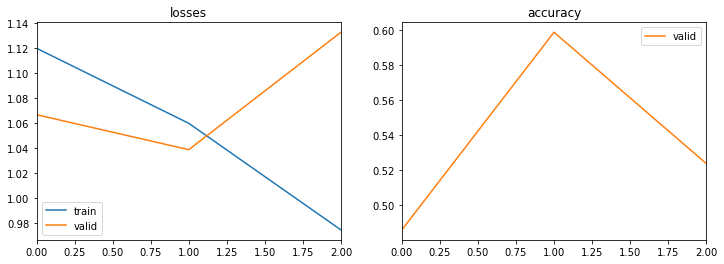

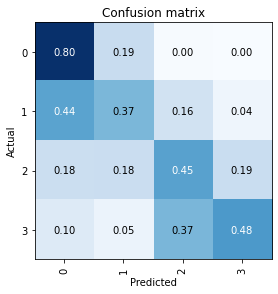

KeyboardInterrupt: 

In [58]:
optimizer.maximize(
    init_points=5,
    n_iter=120,
)

In [45]:
print(optimizer.max)

{'target': 0.53, 'params': {'bidirectional': 0.04885276415550424, 'dropout': 0.30132817137543366, 'fc_dropout': 0.32986395962365067, 'hidden': 129.58894998276662, 'layers': 5.089524547292642, 'model': 0.7000284321534322}}


In [59]:
mlflow.end_run()

In [24]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

In [101]:
X.shape

(6000, 978, 180)

In [102]:
X_noNan[:,:,-7:].shape

torch.Size([6000, 978, 7])

In [103]:
?get_ts_features

In [105]:
ts_features_df3 = get_ts_features(X_noNan[:,:,-7:], y, features='efficient', n_jobs=12)

Feature Extraction:   0%|          | 0/60 [03:20<?, ?it/s]


KeyboardInterrupt: 

Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 43, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 42, in <genexpr>
    results = (map_function(chunk, **kwargs) for chunk in chunk_list)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/sit

  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 43, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
Process ForkPoolWorker-19:
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 43, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 42, in <genexpr>
    results = (map_function(chunk, **kwargs) for chunk in chunk_list)
  File "/home/scottcha/mini

  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/numpy/core/_dtype.py", line 335, in _name_get
    if _name_includes_bit_suffix(dtype):
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/numpy/core/_dtype.py", line 308, in _name_includes_bit_suffix
    if dtype.type == np.object_:
KeyboardInterrupt
Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/utilities/distribution.py", line 43, in _func

  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/feature_extraction/extraction.py", line 314, in _f
    result = func(x, param=parameter_list)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/pandas/core/base.py", line 1245, in value_counts
    result = value_counts(
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/pandas/core/algorithms.py", line 773, in value_counts
    keys, counts = _value_counts_arraylike(values, dropna)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/tsfresh/feature_extraction/feature_calculators.py", line 1968, in friedrich_coefficients
    calculated[m][r] = _estimate_friedrich_coefficients(x, m, r)
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/multiprocessing/process.py", line 1

In [104]:
ts_features_df2 = get_ts_features(X_noNan[:,:,-7:].shape, y, features='efficient', n_jobs=12)

AttributeError: 'torch.Size' object has no attribute 'ndim'

In [28]:
ts_features_df2.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,1__median,...,976__minimum,977__sum_values,977__median,977__mean,977__length,977__standard_deviation,977__variance,977__maximum,977__minimum,target
0,0.015174,0.000085,0.000084,180.0,0.000006,3.085927e-11,0.000118,0.000051,0.022002,0.000123,...,0.095653,17.552877,0.095653,0.097516,180.0,0.006413,0.000041,0.1196,0.095653,1
1,0.015323,0.000085,0.000085,180.0,0.000009,8.504757e-11,0.000153,0.000045,0.022161,0.000123,...,0.095653,17.600769,0.095653,0.097782,180.0,0.006815,0.000046,0.1196,0.095653,2
2,0.015009,0.000085,0.000083,180.0,0.000007,5.273188e-11,0.000117,0.000036,0.021693,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
3,0.014554,0.000085,0.000081,180.0,0.000016,2.549018e-10,0.000113,-0.000006,0.021474,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
4,0.015122,0.000085,0.000084,180.0,0.000005,2.248303e-11,0.000106,0.000056,0.021797,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,3


In [26]:
?get_ts_features

In [71]:
ts_features_df.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,1__median,...,976__minimum,977__sum_values,977__median,977__mean,977__length,977__standard_deviation,977__variance,977__maximum,977__minimum,target
0,0.015174,0.000085,0.000084,180.0,0.000006,3.085927e-11,0.000118,0.000051,0.022002,0.000123,...,0.095653,17.552877,0.095653,0.097516,180.0,0.006413,0.000041,0.1196,0.095653,1
1,0.015323,0.000085,0.000085,180.0,0.000009,8.504757e-11,0.000153,0.000045,0.022161,0.000123,...,0.095653,17.600769,0.095653,0.097782,180.0,0.006815,0.000046,0.1196,0.095653,2
2,0.015009,0.000085,0.000083,180.0,0.000007,5.273188e-11,0.000117,0.000036,0.021693,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
3,0.014554,0.000085,0.000081,180.0,0.000016,2.549018e-10,0.000113,-0.000006,0.021474,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
4,0.015122,0.000085,0.000084,180.0,0.000005,2.248303e-11,0.000106,0.000056,0.021797,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,3


In [73]:
ts_features_df.to_csv('tsfresh_features.csv')

In [8]:
dls.vars

978

In [9]:
dls.c

4

In [7]:
ts_features_df = pd.read_csv(ml_path + 'tsfresh_features_1_co_Day1DangerAboveTreeline_small.csv', index_col=0)

In [9]:
ts_features_df_test = pd.read_csv(ml_path + 'tsfresh_features_1_co_Day1DangerAboveTreeline_small_test.csv', index_col=0)

In [10]:
ts_features_df = pd.concat([ts_features_df, ts_features_df_test])

In [11]:
ts_features_df.shape

(6000, 26591)

In [18]:
ts_features_df.head()

,ABSV_300mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_350mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_250mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_100mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_250mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_200mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_200mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,"ABSV_30mb_min__fft_coefficient__attr_""imag""__coeff_8","ABSV_30mb_min__fft_coefficient__attr_""real""__coeff_9",ABSV_250mb_avg__energy_ratio_by_chunks__num_segments_10__segment_focus_7,...,"ABSV_250mb_min__fft_coefficient__attr_""abs""__coeff_26","ABSV_400mb_min__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""",ABSV_500mb_avg__large_standard_deviation__r_0.2,ABSV_250mb_max__ratio_beyond_r_sigma__r_7,ABSV_1000mb_min__large_standard_deviation__r_0.25,ABSV_50mb_max__variance_larger_than_standard_deviation,ABSV_150mb_max__large_standard_deviation__r_0.2,ABSV_20mb_max__large_standard_deviation__r_0.1,ABSV_350mb_max__symmetry_looking__r_0.05,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.118986,-6.669141,0.0,...,5.766806,0.108495,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.113785,-5.427816,0.0,...,7.430738,-0.029338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.348601,-4.670537,0.0,...,6.966257,-0.002678,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.177518,-5.213164,0.0,...,4.741138,0.100104,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.433710,-3.094756,0.0,...,5.429518,0.000841,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [109]:
ts_features_df2.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,1__median,...,976__minimum,977__sum_values,977__median,977__mean,977__length,977__standard_deviation,977__variance,977__maximum,977__minimum,target
0,0.015174,0.000085,0.000084,180.0,0.000006,3.085927e-11,0.000118,0.000051,0.022002,0.000123,...,0.095653,17.552877,0.095653,0.097516,180.0,0.006413,0.000041,0.1196,0.095653,1
1,0.015323,0.000085,0.000085,180.0,0.000009,8.504757e-11,0.000153,0.000045,0.022161,0.000123,...,0.095653,17.600769,0.095653,0.097782,180.0,0.006815,0.000046,0.1196,0.095653,2
2,0.015009,0.000085,0.000083,180.0,0.000007,5.273188e-11,0.000117,0.000036,0.021693,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
3,0.014554,0.000085,0.000081,180.0,0.000016,2.549018e-10,0.000113,-0.000006,0.021474,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,2
4,0.015122,0.000085,0.000084,180.0,0.000005,2.248303e-11,0.000106,0.000056,0.021797,0.000123,...,0.095653,17.624718,0.095653,0.097915,180.0,0.007003,0.000049,0.1196,0.095653,3


In [13]:
y.shape

(6000,)

In [12]:
ts_features_df['target']=pd.Series(y)

In [13]:
ts_features_df = ts_features_df.fillna(0)

In [14]:
(np.isnan(ts_features_df).any()).any()

False

In [19]:
splits_2

((#5000) [2091,4760,2579,563,4923,4341,1934,81,169,2144...],
 (#1000) [5735,5244,5856,5881,5346,5980,5848,5841,5516,5026...])

In [20]:
??get_tabular_dls

In [29]:
# ts features
cat_names = None
cont_names = ts_features_df2.columns[:-2]
y_names = 'target'
tab_dls2 = get_tabular_dls(ts_features_df2, cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits_2, bs=64)


In [30]:
tab_dls

In [31]:
fastai.__version__

'2.2.5'

In [57]:
ts_features_df.shape

(6000, 26592)

In [70]:
tab_dls2.one_batch()

(tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
 tensor([[-1.5939, -2.0924, -1.5834,  ...,  0.5528,  0.1093, -1.0189],
         [ 0.5028,  0.0144,  0.4996,  ..., -0.1853, -0.1257,  0.5499],
         [ 3.7925,  5.0256,  3.7677,  ..., -0.7102, -0.2435,  0.5499],
         ...,
         [-0.1958,  0.0144, -0.1945,  ..., -0.1863, -0.1260,  0.5499],
         [-0.1880, -0.2757, -0.1868,  ..., -0.7513, -0.2510,  0.5499],
         [-0.0316,  0.0144, -0.0314,  ..., -0.3071, -0.1567,  0.5499]],
        device='cuda:0'),
 tensor([[1],
         [2],
         [1],
         [2],
         [1],
         [3],
         [0],
         [1],
         [3],
         [3],
         [2],
         [0],
         [3],
         [1],
         [0],
         [0],
         [3],
         [1],
         [3],
         [3],
         [2],
         [3],
         [3],
         [2],
         [0],
         [3],
         [3],
         [0],
         [2],
         [0],
         [3],
         [1],
         [3],
        

In [71]:
tab_dls.one_batch()

(tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
 tensor([[ 0.4462,  0.5291, -0.0915,  ..., -0.1621, -0.0764,  0.2057],
         [ 0.8946,  2.1280,  1.1055,  ..., -0.1621, -0.0764,  0.2057],
         [-0.4972,  0.6968, -0.6800,  ..., -0.1621, -0.0764,  0.2057],
         ...,
         [ 0.2907, -0.7004,  0.2721,  ..., -0.1621, -0.0764,  0.2057],
         [-0.5385, -0.6981, -1.1445,  ..., -0.1621, -0.0764,  0.2057],
         [ 1.3359,  0.4597,  1.0967,  ..., -0.1621, -0.0764,  0.2057]],
        device='cuda:0'),
 tensor([[1],
         [2],
         [2],
         [2],
         [2],
         [0],
         [0],
         [3],
         [2],
         [3],
         [2],
         [2],
         [2],
         [3],
         [0],
         [2],
         [0],
         [1],
         [3],
         [3],
         [0],
         [0],
         [1],
         [2],
         [1],
         [0],
         [2],
         [3],
         [0],
         [2],
         [0],
         [3],
         [2],
        

In [80]:
m = LSTMPlus(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.02)
m2 = LSTMPlus(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.02)
tab_model = build_tabular_model(TabModel, dls=tab_dls)
tab_model2 = build_tabular_model(TabModel, dls=tab_dls2)

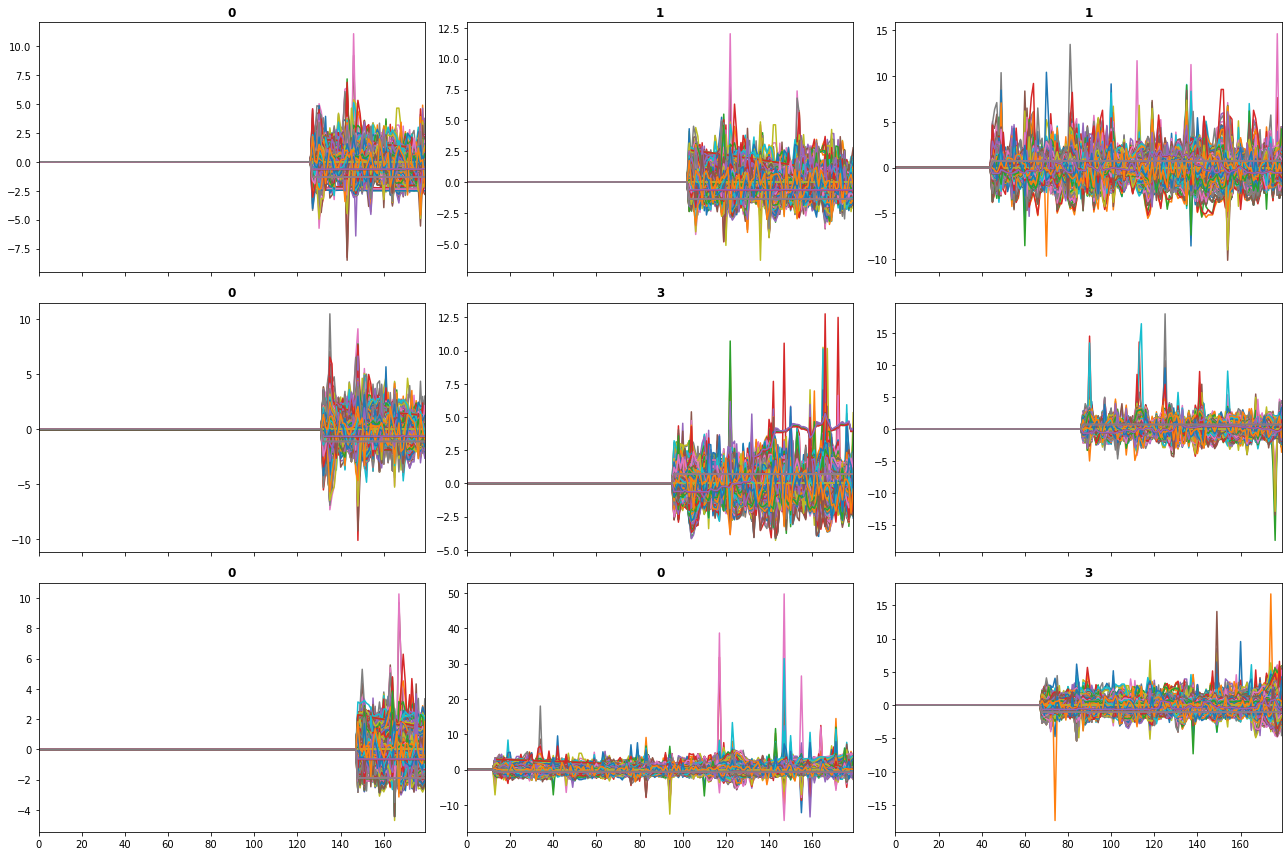

In [33]:
dls.show_batch()

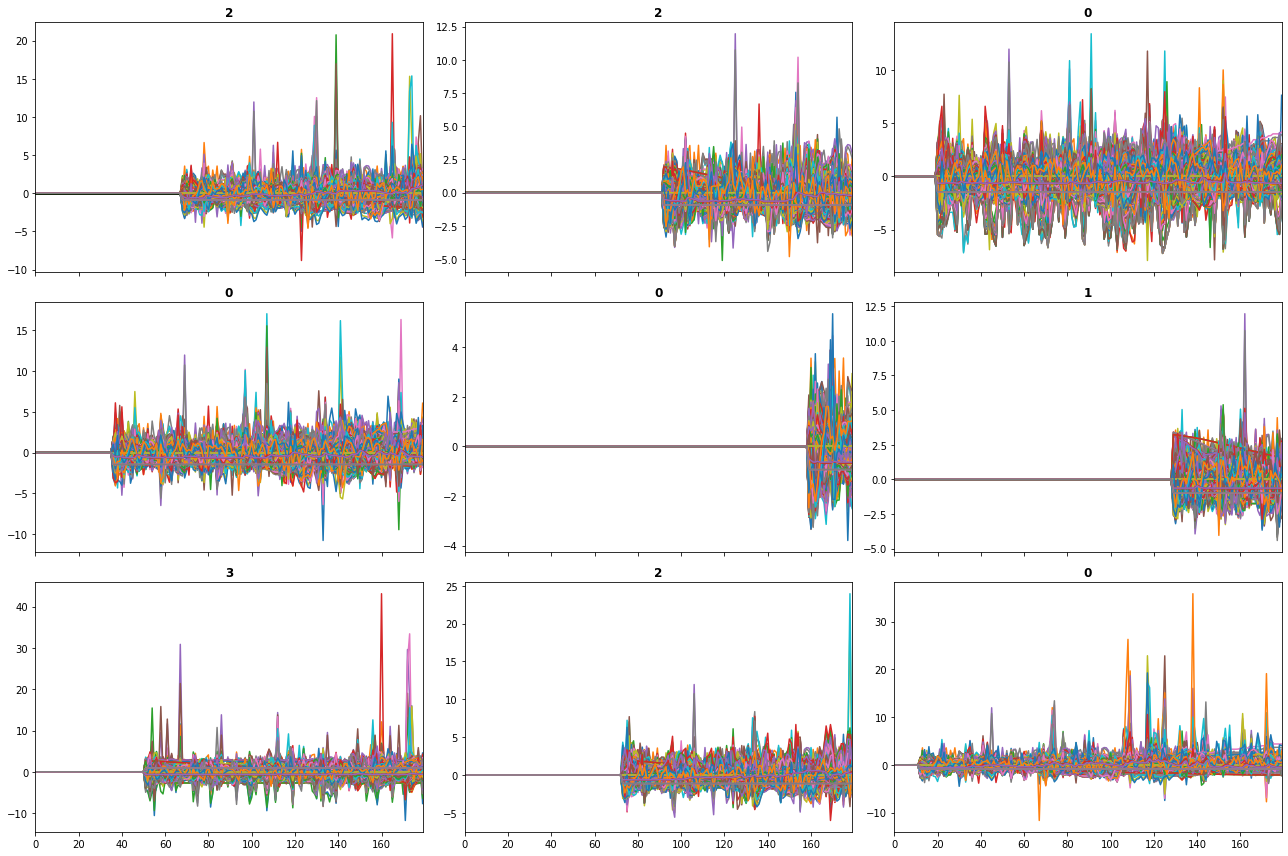

In [69]:
dls.valid.show_batch()

In [73]:
mixed_dls = get_mixed_dls(dls, tab_dls)

In [81]:
mixed_dls2 = get_mixed_dls(dls, tab_dls2)

In [75]:
mixed_dls.one_batch()

((TSTensor(samples:64, vars:978, len:180),
  (tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
   tensor([[-0.5880, -0.6678, -0.8253,  ..., -0.1621, -0.0764,  0.2057],
           [-0.2884, -0.1458, -0.6744,  ..., -0.1621, -0.0764,  0.2057],
           [-0.2110, -0.6384, -0.1325,  ..., -0.1621, -0.0764,  0.2057],
           ...,
           [ 1.0405,  1.3946,  0.4206,  ..., -0.1621, -0.0764,  0.2057],
           [ 0.3049,  0.8305,  0.1348,  ..., -0.1621, -0.0764,  0.2057],
           [ 0.1473, -0.5145, -0.7311,  ..., -0.1621, -0.0764,  0.2057]],
          device='cuda:0'))),
 TensorCategory([1, 1, 0, 2, 0, 3, 2, 0, 1, 3, 0, 1, 3, 2, 0, 1, 2, 2, 3, 0, 3, 0, 0, 0,
         0, 0, 3, 3, 0, 0, 0, 2, 2, 1, 1, 2, 3, 3, 1, 1, 0, 0, 2, 2, 3, 2, 3, 2,
         2, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 0, 2, 3, 3, 2], device='cuda:0'))

In [88]:
mixed_dls2.one_batch()

((TSTensor(samples:64, vars:978, len:180),
  (tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
   tensor([[ 0.3425,  0.0144,  0.3403,  ..., -0.3783, -0.1738,  0.5499],
           [ 0.0979,  0.0144,  0.0973,  ..., -0.8930, -0.2749,  0.5499],
           [ 0.1074,  0.0144,  0.1067,  ..., -0.3232, -0.1606,  0.5499],
           ...,
           [-0.9224, -0.9172, -0.9164,  ..., -0.4695, -0.1946,  0.5499],
           [ 0.5910,  0.0144,  0.5871,  ..., -0.0805, -0.0973, -1.0189],
           [ 0.0019,  0.0144,  0.0019,  ...,  0.7098,  0.1697, -1.0189]],
          device='cuda:0'))),
 TensorCategory([1, 2, 0, 3, 1, 2, 0, 0, 1, 2, 2, 1, 0, 1, 2, 3, 2, 2, 1, 2, 0, 0, 0, 1,
         3, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 2, 2, 0, 3, 3, 0, 1, 0, 0, 3, 2,
         0, 1, 0, 2, 0, 2, 2, 3, 3, 1, 2, 2, 3, 2, 1, 2], device='cuda:0'))

In [83]:
mm = MultiInputNet(m, tab_model)
mm2 = MultiInputNet(m2, tab_model2)

In [98]:
learn = Learner(mixed_dls, mm, metrics=[accuracy, RocAuc()])

In [75]:
??MixedDataLoader

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.002511886414140463)

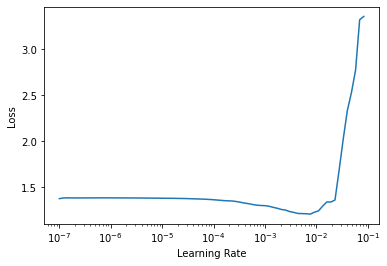

In [43]:
learn.lr_find()

In [99]:
learn.fit_one_cycle(5, lr_max=1e-2)     #, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time


AttributeError: 'tuple' object has no attribute 'dtype'

In [96]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [67]:
??MultiInputNet

In [55]:
tab_dls.one_batch()[0]

tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64)

In [125]:
mixed_dls.one_batch()

((TSTensor(samples:64, vars:978, len:180),
  (tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
   tensor([[-0.6137, -0.4585, -0.2320,  ..., -0.1621, -0.0764,  0.2057],
           [-0.5429,  0.2960,  0.7235,  ..., -0.1621, -0.0764,  0.2057],
           [-0.6730, -0.9986, -0.1529,  ..., -0.1621, -0.0764,  0.2057],
           ...,
           [ 1.6518,  2.0658,  1.5195,  ..., -0.1621, -0.0764,  0.2057],
           [-0.8681, -0.7731, -0.8483,  ..., -0.1621, -0.0764,  0.2057],
           [-0.6693, -0.5232, -0.7758,  ..., -0.1621, -0.0764,  0.2057]],
          device='cuda:0'))),
 TensorCategory([1, 2, 1, 2, 2, 3, 2, 0, 3, 2, 0, 3, 0, 2, 3, 1, 2, 3, 3, 2, 3, 1, 1, 0,
         1, 0, 0, 2, 3, 1, 3, 3, 1, 1, 1, 2, 2, 1, 1, 0, 2, 3, 3, 2, 2, 0, 1, 3,
         1, 1, 3, 0, 1, 0, 0, 2, 2, 3, 2, 1, 0, 3, 0, 2], device='cuda:0'))